<a href="https://colab.research.google.com/github/adithya2208/adithya2208/blob/main/Mushroom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip Mushroom.zip

In [ ]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import numpy as np
from time import time

In [ ]:
os.chdir('/content/Mushroom')
os.listdir()

['Train', 'Test', 'resize.py', '.DS_Store']

In [ ]:
train_dir = pathlib.Path('Train')
test_dir = pathlib.Path('Test')

In [ ]:
batch_size = 64
img_height = 224
img_width = 224
num_classes = 10
epochs = 20
base_learning_rate = 0.01
ft_learning_rate = 0.001

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 10 classes.
Using 720 files for training.


In [ ]:
val_ds = keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 10 classes.
Using 180 files for validation.


In [ ]:
test_ds = keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 10 classes.


In [ ]:
class_names = train_ds.class_names

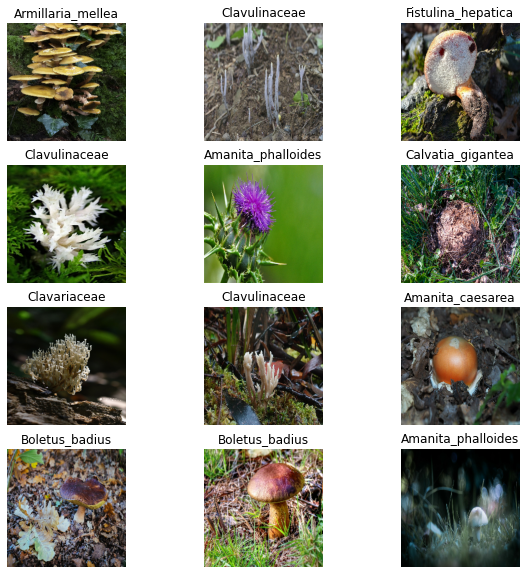

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# MobileNetV2


In [ ]:
base_model = keras.applications.MobileNetV2(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [ ]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ],name="Data_Augmentation"
)
global_average_layer = keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(num_classes,name="Prediction_Layer")

In [ ]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
start = time()
model.evaluate(val_ds)
end = time()
print("Time",end-start)

3/3 [==============================] - 2s 61ms/step - loss: 2.4274 - accuracy: 0.1409
Time 2.4103825092315674


In [ ]:
start = time()
hist1 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)
end = time()
print("Time",end-start)

In [ ]:
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.plot(hist1.history['val_accuracy'])

In [ ]:
os.chdir("/content/Mushroom")
test_ds = keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

start=time()
model.evaluate(test_ds)
end=time()
print("Time",end-start)

In [ ]:
base_model.trainable = True

model.compile(optimizer=keras.optimizers.SGD(learning_rate=ft_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
hist2 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)


In [ ]:
plt.ylim(0,1)
plt.plot(hist2.history['val_accuracy'])

In [ ]:
model.evaluate(test_ds)

In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(model,show_shapes=True)

In [ ]:
#model.summary()

In [ ]:
plt.figure(figsize=(12, 18))
k = 0
os.chdir("/content/Mushroom/Test")
for mush in os.listdir():
  if mush==".DS_Store":
    continue

  os.chdir("/content/Mushroom/Test/"+mush)
  for i in os.listdir():
    if i == ".DS_Store":
      continue
    path = os.getcwd()+"/"+i
    try:
      img = keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width)
      )
      img_array = keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) # Create a batch

      predictions = model.predict(img_array)
      score = tf.nn.softmax(predictions[0])
      if mush != class_names[np.argmax(score)]:
        ax = plt.subplot(5, 2, k + 1)
        k+=1
        plt.axis("off")
        plt.imshow(img)
        title = "Classified as:"+class_names[np.argmax(score)] +" "+ str(np.max(score)) + "\nActual:" + mush
        plt.title(title,fontsize=12)
        if mush in ['Amanita_phalloides','Cortinarius_rubellus','Amanita_bisporigera']:
          if class_names[np.argmax(score)] not in ['Amanita_phalloides','Cortinarius_rubellus','Amanita_bisporigera']:
            plt.title(title,fontsize=12,color='red')
        
          


    except:
      pass

In [ ]:
img = keras.preprocessing.image.load_img(
        '/content/a.jpg', target_size=(img_height, img_width)
      )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
class_names[np.argmax(score)]

# VGG16


In [ ]:
base_model = keras.applications.VGG16(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [ ]:
preprocess_input = keras.applications.vgg16.preprocess_input
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ],name="Data_Augmentation"
)
global_average_layer = keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(num_classes,name="Prediction_Layer")

In [ ]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.evaluate(val_ds)

In [ ]:
start = time()
hist1 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)
end = time()
print("Time",end-start)

In [ ]:
plt.ylim(0,1)
plt.plot(hist1.history['val_accuracy'])

In [ ]:
os.chdir("/content/Mushroom")
start = time()
model.evaluate(test_ds)
end = time()
print("TIME",end-start)

In [ ]:
base_model.trainable = True
model.compile(optimizer=keras.optimizers.SGD(learning_rate=ft_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
hist2 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)


In [ ]:
plt.ylim(0,1)
plt.plot(hist2.history['val_accuracy'])

In [ ]:
model.evaluate(test_ds)

# Resnet50

In [ ]:
base_model = keras.applications.ResNet50(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ],name="Data_Augmentation"
)
global_average_layer = keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(num_classes,name="Prediction_Layer")

In [ ]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
start = time()
hist1 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)
end = time()
print("Time",end-start)

In [ ]:
plt.ylim(0,1)
plt.plot(hist1.history['val_accuracy'])

In [ ]:
os.chdir("/content/Mushroom")
start = time()
model.evaluate(test_ds)
end = time()
print("TIME",end-start)

In [ ]:
base_model.trainable = True
model.compile(optimizer=keras.optimizers.SGD(learning_rate=ft_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
hist2 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

plt.ylim(0,1)
plt.plot(hist2.history['val_accuracy'])

model.evaluate(test_ds)


# Xception

In [ ]:
base_model = keras.applications.Xception(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [ ]:
preprocess_input = keras.applications.xception.preprocess_input
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ],name="Data_Augmentation"
)
global_average_layer = keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(num_classes,name="Prediction_Layer")

In [ ]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
start = time()
hist1 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)
end = time()
print("Time",end-start)

In [ ]:
plt.ylim(0,1)
plt.plot(hist1.history['val_accuracy'])

In [ ]:
os.chdir("/content/Mushroom")
start = time()
model.evaluate(test_ds)
end = time()
print("TIME",end-start)

In [ ]:
base_model.trainable = True
model.compile(optimizer=keras.optimizers.SGD(learning_rate=ft_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
hist2 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

plt.ylim(0,1)
plt.plot(hist2.history['val_accuracy'])

model.evaluate(test_ds)


# Inception-ResNet-V2

In [ ]:
base_model = keras.applications.InceptionResNetV2(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [ ]:
preprocess_input = keras.applications.inception_resnet_v2.preprocess_input
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ],name="Data_Augmentation"
)
global_average_layer = keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(num_classes,name="Prediction_Layer")

In [ ]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
start = time()
hist1 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)
end = time()
print("Time",end-start)

In [ ]:
plt.ylim(0,1)
plt.plot(hist1.history['val_accuracy'])

In [ ]:
os.chdir("/content/Mushroom")
start = time()
model.evaluate(test_ds)
end = time()
print("TIME",end-start)

In [ ]:
base_model.trainable = True
model.compile(optimizer=keras.optimizers.SGD(learning_rate=ft_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
hist2 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

plt.ylim(0,1)
plt.plot(hist2.history['val_accuracy'])

model.evaluate(test_ds)


# Learning Rate/Optimization

In [ ]:
plots = []
for lr in [0.001,0.01,0.1]:
  base_model = keras.applications.MobileNetV2(input_shape=(img_height,img_width,3),
                                                include_top=False,
                                                weights='imagenet')
  base_model.trainable = False
  preprocess_input = keras.applications.mobilenet_v2.preprocess_input
  data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                  input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ],name="Data_Augmentation"
  )
  global_average_layer = keras.layers.GlobalAveragePooling2D()
  prediction_layer = keras.layers.Dense(num_classes,name="Prediction_Layer")
  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = keras.Model(inputs, outputs)
  model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  start = time()
  hist1 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)
  end = time()
  print("Time",end-start)
  plots.append(hist1.history['val_accuracy'])

In [ ]:
plt.figure(figsize=(6,4))
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.plot(plots[0])
plt.plot(plots[1])
plt.plot(plots[2])
plt.legend(["0.001","0.01","0.1"])
plt.title("Learning Rate")

In [ ]:
optim = []

optim.append(keras.optimizers.SGD(learning_rate=base_learning_rate))
optim.append(keras.optimizers.Adam(learning_rate=base_learning_rate))
optim.append(keras.optimizers.RMSprop(learning_rate=base_learning_rate))
optim.append(keras.optimizers.Adadelta(learning_rate=base_learning_rate))
optim.append(keras.optimizers.Adagrad(learning_rate=base_learning_rate))
optim.append(keras.optimizers.Adamax(learning_rate=base_learning_rate))

plots = []
for op in optim:
  base_model = keras.applications.MobileNetV2(input_shape=(img_height,img_width,3),
                                                include_top=False,
                                                weights='imagenet')
  base_model.trainable = False
  preprocess_input = keras.applications.mobilenet_v2.preprocess_input
  data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                  input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ],name="Data_Augmentation"
  )
  global_average_layer = keras.layers.GlobalAveragePooling2D()
  prediction_layer = keras.layers.Dense(num_classes,name="Prediction_Layer")
  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = keras.Model(inputs, outputs)
  model.compile(optimizer=op,
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  start = time()
  hist1 = model.fit(train_ds,epochs=epochs,validation_data=val_ds)
  end = time()
  print("Time",end-start)
  plots.append(hist1.history['val_accuracy'])

In [ ]:
plt.figure(figsize=(6,4))
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(plots[0])
plt.plot(plots[1])
plt.plot(plots[2])
plt.plot(plots[4])
plt.plot(plots[5])
plt.legend(["SGD","Adam","RMS","Adagrad","Adamax"])
plt.title("Optimizers")

In [ ]:
plots[3]